<a href="https://colab.research.google.com/github/JennyPre/ReinforcementSimple/blob/main/LunarLander.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [58]:
! pip install gymnasium
! pip install torch torchvision
! pip install numpy matplotlib
! pip install imageio imageio-ffmpeg
! pip install mediapy
! pip install swig
! pip install "gymnasium[box2d]"

# for use of framework for PPO
! pip install stable-baselines3[extra]


In [59]:
import gymnasium as gym
import mediapy as media
import torch
from stable_baselines3 import PPO
from stable_baselines3.common.env_util import make_vec_env

In [21]:
torch.cuda.is_available()
torch.cuda.device_count()
torch.cuda.current_device()
torch.cuda.device(0)
# torch.cuda.get_device_name(0)

# Lunar Lander

This problem represents an optimization problem, where the engine is either full on or turned of (Pontryagin's maximum principle).

The rockets trajectory should be optimized such that the rocket lands at the landing area (0,0). Environment is either discrete or continuous, here a discrete environment will be used.

The amount of fuel is not restricted, which is beneficial for learning.


Without learning, a heuristic landing run looks like this
```!python /content/lunar_lander.py```


 | Step | x_position | y_position | x_velocity | y_velocity | angle | angular_velocity | left_leg_contact | right_leg_contact | Total Reward |
|------|------------|----------|------------|------------|-------|------------------|------------------|-------------------|--------------|
| 0    | -0.00      | +1.43    | -0.10      | +0.45      | +0.00 | -0.02            | +0.00            | +0.00             | +1.85        |
| 20   | -0.02      | +1.51    | -0.10      | -0.09      | -0.02 | -0.02            | +0.00            | +0.00             | +24.63       |
| 40   | -0.04      | +1.34    | -0.10      | -0.62      | -0.04 | -0.02            | +0.00            | +0.00             | -10.26       |
| 60   | -0.07      | +0.94    | -0.12      | -1.08      | -0.06 | -0.04            | +0.00            | +0.00             | -18.42       |
| 80   | -0.07      | +0.55    | +0.00      | -0.68      | -0.06 | -0.00            | +0.00            | +0.00             | +55.71       |
| 100  | -0.07      | +0.32    | +0.02      | -0.41      | -0.08 | +0.02            | +0.00            | +0.00             | +97.02       |
| 120  | -0.06      | +0.18    | +0.11      | -0.26      | -0.05 | +0.08            | +0.00            | +0.00             | +121.93      |
| 140  | -0.04      | +0.09    | +0.10      | -0.19      | +0.01 | +0.05            | +0.00            | +0.00             | +138.54      |
| 160  | -0.02      | +0.02    | +0.03      | -0.10      | +0.04 | +0.01            | +0.00            | +0.00             | +147.82      |
| 180  | -0.02      | -0.00    | +0.00      | +0.03      | -0.01 | +0.10            | +1.00            | +1.00             | +178.68      |
| 200  | -0.02      | -0.00    | -0.00      | -0.00      | -0.00 | +0.00            | +1.00            | +1.00             | +182.39      |
| 207  | -0.02      | -0.00    | +0.00      | +0.00      | -0.00 | +0.00            | +1.00            | +1.00             | +282.39      |



Episode finished after 73 timesteps. Cummulative return: -102.62776871256125


""

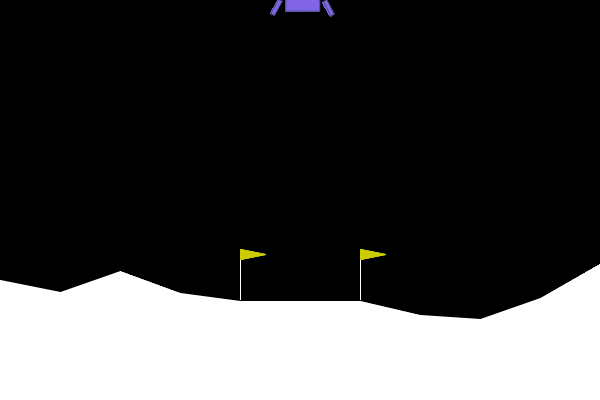

In [35]:
env = gym.make("LunarLander-v3", render_mode="rgb_array")

frames = []
observation, info = env.reset()
rewards = []


for t in range(100):
  action = env.action_space.sample()
  frames.append(env.render())
  observation, reward, terminated, truncated, info = env.step(action)
  done = terminated or truncated
  rewards.append(reward)

  if done:
    print(f"Episode finished after {t+1} timesteps. Cummulative return: {sum(rewards)}")
    break

media.show_video(frames, fps=10, codec='gif')

In [12]:
# ! python /content/lunar_lander.py

## Action Space

The action space allows four action, hence is discrete:

- do nothing (0)
- fire left orientation engine (1)
- fire main engine (2)
- fire right orientation engine (3)

## Observation Space

Is a vector:

```
(lander_x,
lander_y,
velocity_x,
velocity_y,
lander_angle,
angular_velocity,
left_leg_ground_contact,
right_leg_ground_contact
)
```

## Rewards


An episode consists of n steps, for each step a reward is given. The rewards are summed up within an episode.

The reward for a step is calculated as follows:

- distance to the landing pad
- moving speed of the lander
- angle of the lander (bigger angle leads to bigger decrease)
- +10 points for each leg on the ground
- -0.03 points per frame the side engine fires
- -0.3 points per frame the main engine fires

-100/+100: save landing

A successfull episode is an episode that scores at least 200 points.

In [13]:
print(env.action_space)  # Should be Discrete(4)

Discrete(4)


## Proximal Policy Optimization


PPO is an **Actor-Critic** policy gradient algorithm. It updates the policy within a "trust region" to avoid catastrophically worsening performance.


### Actor-Critic

PPO uses TWO neural networks (or two output heads from a shared network):

1. **Actor (Policy Network)**: Learns π_θ(a|s) - outputs action probability distribution
2. **Critic (Value Network)**: Learns V_ϕ(s) - outputs state-value estimates


This combines:
- **Policy-based**: Directly learns a policy (distribution over actions)
- **Value-based**: Learns a state-value function V(s) to estimate "how good is this state?"

```
┌─────────────────────────────────────────────────┐
│  CRITIC  =  Value Function  =  V(s)             │
│  "How good is this state?"                      │
│                                                 |
│  Input:  State s                                │
│  Output: Single number (estimated value)        │
│  Example: V(s) = 42.7                           │
└─────────────────────────────────────────────────┘

┌─────────────────────────────────────────────────┐
│  ACTOR   =  Policy  =  π(a|s)                   │
│  "What action should I take?"                   │
│                                                 │
│  Input:  State s                                │
│  Output: Probability distribution over actions  │
│  Example: π(a|s) = [0.1, 0.7, 0.2, 0.0]         │
└─────────────────────────────────────────────────┘
```



### Policy Ratio - Actor

This ratio describes the relation between old and new policies. A policy is parameterized by the weights of it's neural network θ, and is depdendent on the states $s$ and actions $a$:

$$r_t(\theta) = \frac{\pi_\theta(a_t|s_t)}{\pi_{\theta_{old}}(a_t|s_t)}$$

- If r_t > 1: action became more likely under new policy
- If r_t < 1: action became less likely under new policy

## Objective Function

The PPO maximizes the following clipped objective. The clipping will prevent large policy updates.


$$L^{CLIP}(\theta) = \mathbb{E}_t[\min(r_t(\theta)\hat{A}_t, \text{clip}(r_t(\theta), 1-\epsilon, 1+\epsilon)\hat{A}_t)]$$

The clipping restricts r_t to [1-ε, 1+ε].

### Advantage Function (GAE)

This function quantifies how much better an action was than expected. For PPO Generalized Advantage Estimation (GAE) is often used:

$$\hat{A}_t = \delta_t + (\gamma\lambda)\delta_{t+1} + (\gamma\lambda)^2\delta_{t+2} + ...$$

where
- $\delta_t = r_t + \gamma V(s_{t+1}) - V(s_t)$ is the TD (Temporal difference) error,
  - $V(s_t)$ = **critic's estimate** of current state value
  - $V(s_{t+1})$ = **critic's estimate** of next state value
- $\gamma$: discount factor
- $\lambda$ controls bias-variance tradeoff.

### Critic function 

The **Critic loss** quantifies the difference between the predicted and actual returns. Here MSE is used.

$$L^{VF} = (V_\theta(s_t) - V_t^{target})^2$$


### Entropy bonus/loss

**Entropy bonus** encourages exploration.

$$S[\pi_\theta] = -\sum_a \pi_\theta(a|s)\log\pi_\theta(a|s)$$


### Loss Function

The loss function combines the previous three terms:

$$L(\theta) = L^{CLIP}(\theta) - c_1 L^{VF}(\theta) + c_2 S[\pi_\theta](s_t)$$

- coefficients: $c_1$ and $c_2$


## PPO Algorithm

The algorithm repeatedly alternates between data collection and policy updates:

1. The agent interacts with the environment using the current policy, collecting trajectories of $(s_t, a_t, r_t, s_{t+1})$ tuples. It also computes V(s_t) for each state using the **critic network**
2. Compute Advantages:
   - Calculate TD (temporal difference) errors: $δ_t$
   - Calculate GAE advantages: $Â_t$ using the TD errors
   - Calculate target returns: $V_t^{target}$ for training the critic
3. Shuffle the collected data and update the policy network and critic network multiple epochs (typically 3-10) using minibatches, optimizing the full loss function
4. Repeat


PPO reuses the same batch of experience multiple times, before collecting new data. This makes it more sample-efficient compared to vanilla policy gradients.



In [60]:
# Reset the environment to generate new observations
observation, info = env.reset(seed=42)

In [ ]:
model = PPO("MlpPolicy", env, verbose=1)
model.learn(total_timesteps=500000)
model.save("ppo_lunarlander")

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 96.1     |
|    ep_rew_mean     | -174     |
| time/              |          |
|    fps             | 671      |
|    iterations      | 1        |
|    time_elapsed    | 3        |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 98.9        |
|    ep_rew_mean          | -187        |
| time/                   |             |
|    fps                  | 529         |
|    iterations           | 2           |
|    time_elapsed         | 7           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.009390112 |
|    clip_fraction        | 0.0725      |
|    clip_range           | 0.2         |
|    entropy_loss  

In [57]:
model = PPO.load("ppo_cartpole")

/home/jenny/anaconda3/envs/reinforcement-learning/lib/python3.12/site-packages/stable_baselines3/common/on_policy_algorithm.py:150: UserWarning: You are trying to run PPO on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(


In [56]:
oberservation, info = env.reset()

total_reward = 0

for i in range(1000):
    # here the policy is used to predict
    action, _states = model.predict(observation, deterministic=True)

    # make the action in the environment
    observation, reward, terminated, truncated, info = env.step(action)
    total_reward += reward

    if terminated or truncated:
        print(f"Episode finished after {i+1} steps with total reward: {total_reward}")
        observation, info = env.reset()
        total_reward = 0


env.close()

Episode finished after 319 steps with total reward: -372.969006539403
Episode finished after 629 steps with total reward: -342.58628541093844
Episode finished after 976 steps with total reward: -403.9471931424692


In [ ]:


# for _ in range(1000):

#     # this is where you would insert your policy
#     action = env.action_space.sample()

#     # step (transition) through the environment with the action
#     # receiving the next observation, reward and if the episode has terminated or truncated
#     observation, reward, terminated, truncated, info = env.step(action)

#     # If the episode has ended then we can reset to start a new episode
#     if terminated or truncated:
#         observation, info = env.reset()

# env.close()


Phase 2: Simple PPO Training (1-2 hours)
Hints:

Start with default hyperparameters - don't tune yet!
Use PPO("MlpPolicy", env, verbose=1) - the MlpPolicy automatically creates the Actor-Critic networks
Train for 500k timesteps initially (about 500 episodes)
Save the model periodically (every 100k steps)
Key insight: You don't need to write the neural networks, loss functions, or training loop - the framework handles it!

Phase 3: Monitoring & Visualization (ongoing)
What to track:

Episode rewards (should trend upward from ~-200 toward +200)
Episode length (should decrease as it learns to land faster)
Policy loss and value loss (should stabilize)
Explained variance (should be high, >0.5, means critic is learning well)

Tools to use:

TensorBoard for real-time plots (just pass tensorboard_log="./ppo_lunar_logs/")
Matplotlib for custom plots after training
Save episode reward history in a list

Phase 4: Evaluation (30 mins)
Important hints:

Train and test are different!
When testing, use deterministic=True in predict() - takes the mean action instead of sampling
Evaluate over 100 episodes (that's the official benchmark)
Calculate mean and std of rewards
Render a few episodes to watch it perform

Phase 5: Hyperparameter Tuning (optional, 2-4 hours)
What to experiment with:

Learning rate: Try [1e-4, 3e-4, 1e-3]
n_steps: Try [1024, 2048] (more steps = more stable but slower)
batch_size: Try [32, 64, 128]
Network architecture: Try policy_kwargs=dict(net_arch=[256, 256]) for bigger networks

Pro tip: Change ONE hyperparameter at a time, train for 500k steps, compare results
🚨 Common Pitfalls to Avoid

Not waiting long enough - PPO can take 500k-2M timesteps, be patient!
Forgetting to set random seed - makes experiments reproducible
Not using render_mode="rgb_array" during training - "human" mode is slow
Evaluating with stochastic policy - always use deterministic=True for testing
Not saving models - you'll want to keep the best performer!

🎓 Learning Opportunities
While the framework trains, think about:

What is the Actor network actually outputting? (4 probabilities)
What is the Critic network predicting? (scalar value of state)
How does clipping prevent bad updates?
Why do we need separate Actor and Critic?
What would happen without GAE?

Questions to explore in the logs:

When does learning "click"? (sudden jump in rewards)
Does it ever plateau or regress?
How stable is the learning curve?

📊 Success Criteria
You'll know it's working when:

✅ Episode rewards go from ~-200 to ~+200
✅ The agent lands consistently (watch a few episodes)
✅ Average reward >200 over 100 episodes = SOLVED
✅ Policy loss and value loss are stable (not exploding)

🔄 Iteration Strategy
First run: Use all defaults, just see it work
Second run: Increase training timesteps to 1M if not solved
Third run: Tune ONE hyperparameter based on what you observed
Fourth run: Try different policy architecture if needed
💡 Pro Tips

Use callbacks - Stable-Baselines3 has EvalCallback to automatically save the best model
Compare with benchmarks - Your knowledge base says PPO is variable but stable
Visualize the policy - After training, render episodes to see what it learned
Check GPU usage - PPO should use your GPU if available (check with nvidia-smi)

🎯 Your First Goal
Make this work with zero code complexity:

Load environment
Create PPO with defaults
Train for 500k steps
Evaluate and render

That's it! Get the end-to-end pipeline working first, then worry about optimization.

## TODO: Q-learning

## TODO: DQN-Agent



## Stable-Baselines3